In [70]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq 
using BenchmarkTools
using Libdl

In [71]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(f, op_list, N, n, d0_lb, compute_t_evolution, fcounter)
    popup_ss, nbr_error_ss = [], []
    popup_t, nbr_error_t, list_t = [], [], []

    i=1
    
    # Compute distribution only for the full hamiltonian, for the reduced one we take the already existing one (to compare)
    if fcounter == 1
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L
    else
        @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L
    end


    # Compute the parameters
    system = SpinCollection(r0, e, gammas=1.)
    Ω_CS = OmegaMatrix(system)
    Γ_CS = GammaMatrix(system)
    Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
    Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
    exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
    conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
    p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])
    
        # Load the functions
    fsolve(du, u, p, t) = functions[fcounter](du, u, p0)

    phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4 # We start from all the atoms in the GS
    uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

    ## Computation steady state ##
    prob_ss = SteadyStateProblem(fsolve, uf)
    sol_ss = solve(prob_ss, DynamicSS(DP5()); abstol=1e-3, reltol=1e-3) # ; maxiters=10_000, abstol=1e-1, reltol=1e-1
    if SciMLBase.successful_retcode(sol_ss)
            push!(popup_ss, sum(real(sol_ss[1:N])))
        else
            push!(nbr_error_ss, i)
            push!(popup_ss, [-1])
    end

    ## Computation time evolution ##
    if compute_t_evolution
        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))

        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5();
                    reltol=1.0e-5,
                    abstol=1.0e-5)

        if SciMLBase.successful_retcode(sol)
            push!(list_t, sol.t)
            push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(sol.t)])
        else
            push!(nbr_error_t, i)
        end
    end
    return popup_ss, nbr_error_ss, popup_t, nbr_error_t, list_t
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end


""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end

load_f

### Define the system

In [72]:
# Nbr of particles
N = 2
r = 1 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 1e3 # atoms per unit of volume (already normalized)
d0_lb = 1e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ
d0_lb = d0_lb/λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 0.1
T = [0:tstep:100;]; # Normalised time

### Compute stationnary state for r repetitions

In [73]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [74]:
# Prepare the wrapper
const N_FUNCS = 2  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)

functions[1] = load_f("diffeqf", "libs/liballfuncs_$N.dll")
functions[2] = load_f("diffeqf", "libs/liballfuncs_$(N)_no_Helec.dll");

In [75]:
@load "op_list/op_list_$N.jdl2" op_list

popup_ss, nbr_error_ss, popup_t, nbr_error_t, liste_t = solve_random_distrib(functions, op_list, N, n0, d0_lb, true, 1) # fcounter=1 : Full Hamiltonian

(Any[0.007338394172551017], Any[], Any[[7.498798913309288e-33, 4.675540857974782e-10, 5.6518493926729866e-8, 5.698526728716257e-6, 0.0005145776839265312, 0.0025805813390975436, 0.00601145175818445, 0.009396260302772016, 0.011095586271788735, 0.010581392736413238  …  0.007398153489866457, 0.00739835032886239, 0.007398543334459639, 0.007398732604382976, 0.007398918230690436, 0.007399100299893566, 0.007399278893271493, 0.007399454085714945, 0.007399625942138607, 0.0073996382206911945]], Any[], Any[[0.0, 9.999999999999999e-5, 0.0010999999999999998, 0.011099999999999997, 0.11109999999999996, 0.2733226522090664, 0.4777534845577115, 0.7170659659164252, 0.9820167460099158, 1.2686968371863236  …  95.35894884888933, 95.9310528249908, 96.50380772284734, 97.07729863456846, 97.65160379351988, 98.22679382244783, 98.80293157665247, 99.38006713462877, 99.95822394373612, 100.0]])

In [76]:
@save "solutions/sol_N_$(N)_r_$(r)" popup_ss nbr_error_ss popup_t nbr_error_t liste_t

In [77]:
@load "solutions/sol_N_$(N)_r_$(r)" popup_ss nbr_error_ss popup_t nbr_error_t liste_t

5-element Vector{Symbol}:
 :popup_ss
 :nbr_error_ss
 :popup_t
 :nbr_error_t
 :liste_t

# Without $H_{Elec DD}$

In [80]:
@load "op_list/op_list_$(N)_no_Helec.jdl2" op_list

popup_ss_no_Helec, nbr_error_ss_no_Helec, popup_t_no_Helec, nbr_error_t_no_Helec, liste_t_no_Helec = solve_random_distrib(functions, op_list, N, n0, d0_lb, true, 2) # fcounter=2 : Reduced Hamiltonian

(Any[0.05034205198629241], Any[], Any[[7.498798913309288e-33, 4.675540883015143e-10, 5.6518530552341695e-8, 5.698902768268794e-6, 0.0005179921283101859, 0.0042081240417725305, 0.010839671198268098, 0.019914712628101607, 0.0287799044088518, 0.03643566600743245  …  0.05198039926623156, 0.05195608082197853, 0.051978430291873365, 0.05199504125195713, 0.051969794968903756, 0.05198891186116329, 0.052007903818835646, 0.05198193354915545, 0.051997487736867846, 0.05199920222936929]], Any[], Any[[0.0, 9.999999999999999e-5, 0.0010999999999999998, 0.011099999999999997, 0.11109999999999996, 0.35549292379411185, 0.6525174177956004, 1.0442052993353204, 1.4986744634510978, 2.040973714241871  …  87.3348199255125, 88.80551423628663, 90.24434830208992, 91.78846320711841, 93.25491096732966, 94.70560924998412, 96.24717988551977, 97.70127858375947, 99.16029018416327, 100.0]])

In [81]:
@save "solutions/sol_N_$(N)_r_$(r)" popup_ss_no_Helec nbr_error_ss_no_Helec popup_t_no_Helec nbr_error_t_no_Helec liste_t_no_Helec

In [82]:
@load "solutions/sol_N_$(N)_r_$(r)" popup_ss_no_Helec nbr_error_ss_no_Helec popup_t_no_Helec nbr_error_t_no_Helec liste_t_no_Helec

5-element Vector{Symbol}:
 :popup_ss_no_Helec
 :nbr_error_ss_no_Helec
 :popup_t_no_Helec
 :nbr_error_t_no_Helec
 :liste_t_no_Helec

# Compare with/without $H_{ElecDD}$

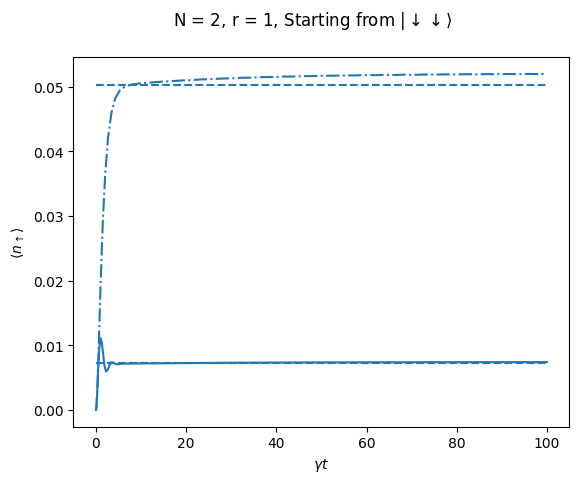

In [85]:
close("all")
fig, ax = subplots()
i=1

line, = ax.plot(liste_t[i], popup_t[i])
line_no_Helec, = ax.plot(liste_t_no_Helec[i], popup_t_no_Helec[i], linestyle = "-.", color = line.get_color())

# Plot the SS
if i ∉ nbr_error_ss
    ax.hlines(popup_ss[i], T[1], T[end], linestyle="--", color = line.get_color())
end
if i ∉ nbr_error_ss_no_Helec
    ax.hlines(popup_ss_no_Helec[i], T[1], T[end], linestyle="--", color = line_no_Helec.get_color())
end

ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

# Brouillons

In [86]:

        # if compute_t_evolution
        #     phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        #     u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        #     prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))

        #     sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5();
        #                 reltol=1.0e-5,
        #                 abstol=1.0e-5) # , saveat=T

        #     if SciMLBase.successful_retcode(sol)
        #         push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(T)])
        #     else
        #         push!(nbr_error_t, i)
        #     end
        #     uf = sol.u[end]

        # else